Goal of this notebook: implement some basic RNN/LSTM/GRU to _forecast_ trajectories based on VIRAT and/or the custom _hof_ dataset.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt # Visualization 
import torch.nn as nn
import pandas_helper_calc  # noqa # provides df.calc.derivative()
import pandas as pd
import cv2
import pathlib
from tqdm.autonotebook import tqdm

/home/ruben/suspicion/trap/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
FPS = 12
# SRC_CSV = "EXPERIMENTS/hofext-maskrcnn/all.txt"
# SRC_CSV = "EXPERIMENTS/raw/generated/train/tracks.txt"
SRC_CSV = "EXPERIMENTS/raw/hof-meter-maskrcnn2/train/tracks.txt"
SRC_CSV = "EXPERIMENTS/20240426-hof-yolo/train/tracked.txt"
SRC_CSV = "EXPERIMENTS/raw/hof2/train/tracked.txt"
# SRC_H = "../DATASETS/hof/webcam20231103-2-homography.txt"
SRC_H = None
CACHE_DIR = "EXPERIMENTS/cache/hof2/"
SMOOTHING = True # hof-yolo is already smoothed, hof2 isn't
SMOOTHING_WINDOW=3 #2

In [3]:
in_fields = ['proj_x', 'proj_y', 'vx', 'vy', 'ax', 'ay']
# out_fields = ['v', 'heading']
# velocity cannot be negative, and heading is circular (modulo), this makes it harder to optimise than a linear space, so try to use components
# an we can use simple MSE loss (I guess?)
out_fields = ['vx', 'vy']
window = int(FPS*1.5)

In [4]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# Hyperparameters
input_size = len(in_fields)
hidden_size = 256
num_layers = 3
output_size = len(out_fields)
learning_rate = 0.005 #0.01 #0.005
batch_size = 256
num_epochs = 1000

cuda


In [5]:
cache_path = pathlib.Path(CACHE_DIR)
cache_path.mkdir(parents=True, exist_ok=True)

In [6]:
from pathlib import Path
from trap.tools import load_tracks_from_csv

data = load_tracks_from_csv(Path(SRC_CSV), FPS, 2, 5 )

Samping 1/5, of 412098 items
Done sampling kept 83726 items


frame_id  track_id            l           t           w           h  \
194     606.0         4  1593.885864  782.814819  145.704346  195.380432   
199     611.0         4  1563.890015  700.710510  137.461304  190.194855   
204     616.0         4  1529.469727  635.622498  129.342651  194.191528   
209     621.0         4  1474.449341  569.387634  128.099854  199.766357   
214     626.0         4  1443.123535  518.907043  120.022461  202.566772   
219     631.0         4  1398.944946  461.813049  106.391357  193.476410   
224     636.0         4  1353.237793  438.118896   91.444336  170.930664   
229     641.0         4  1272.791992  408.827759  104.274536  180.414551   
234     646.0         4  1198.965820  407.952759  103.282104  167.306580   
239     651.0         4  1156.309570  415.743408   97.628784  158.774811   
244     656.0         4  1094.440430  443.849915  107.938110  177.703979   
249     661.0         4  1072.595093  481.461945  118.452148  205.365173   
254     666.0         4  1086.627930  526.733154  105.444458  189.750610   
259     671.0         4  1099.592285  584.216675  114.395874  218.003479   
264     676.0         4  1144.484782  642.779582   96.750326  180.744690   
269     681.0         4  1179.532959  682.365540  107.764282  200.651733   

             x          y  state  diff  ...        dx        dy        vx  \
194  12.897830  10.750061    2.0   NaN  ...  0.201965 -0.291350  0.484716   
199  13.099794  10.458712    1.0   5.0  ...  0.201965 -0.291350  0.484716   
204  13.020002   9.866642    2.0   5.0  ... -0.079792 -0.592069 -0.191501   
209  12.965776   9.301442    2.0   5.0  ... -0.054226 -0.565200 -0.130143   
214  12.642992   8.976624    2.0   5.0  ... -0.322784 -0.324818 -0.774681   
219  12.465588   8.557788    2.0   5.0  ... -0.177404 -0.418836 -0.425771   
224  12.128433   8.052323    2.0   5.0  ... -0.337155 -0.505465 -0.809172   
229  11.689648   7.684636    2.0   5.0  ... -0.438785 -0.367687 -1.053084   
234  11.207276   7.476216    2.0   5.0  ... -0.482372 -0.208420 -1.157693   
239  10.884154   7.514692    2.0   5.0  ... -0.323122  0.038476 -0.775493   
244  10.544492   7.870090    2.0   5.0  ... -0.339661  0.355398 -0.815187   
249  10.486504   8.287758    2.0   5.0  ... -0.057989  0.417668 -0.139173   
254  10.498393   8.684043    2.0   5.0  ...  0.011889  0.396285  0.028534   
259  10.492767   9.267106    2.0   5.0  ... -0.005626  0.583063 -0.013502   
264  10.484691   9.582745    1.0   5.0  ... -0.008077  0.315639 -0.019384   
269  10.698373   9.950516    2.0   5.0  ...  0.213682  0.367771  0.512837   

           vy        ax        ay         v         a     heading   d_heading  
194 -0.699240 -1.622919 -1.732144  0.850815  1.399195  304.729842 -101.772559  
199 -0.699240 -1.622919 -1.732144  0.850815  1.399195  304.729842 -101.772559  
204 -1.420966 -1.622919 -1.732144  1.433812  1.399195  262.324609 -101.772559  
209 -1.356479  0.147259  0.154769  1.362708 -0.170650  264.519715    5.268254  
214 -0.779564 -1.546892  1.384597  1.099023 -0.632844  225.179993  -94.415332  
219 -1.005205  0.837386 -0.541539  1.091659 -0.017675  247.044148   52.473972  
224 -1.213117 -0.920163 -0.498987  1.458222  0.879752  236.295957  -25.795658  
229 -0.882448 -0.585388  0.793604  1.373936 -0.202286  219.961870  -39.201809  
234 -0.500209 -0.251064  0.917374  1.261136 -0.270721  203.367915  -39.825493  
239  0.092343  0.917282  1.422125  0.780971 -1.152395  173.209381  -72.380481  
244  0.852955 -0.095267  1.825468  1.179857  0.957326  133.703018  -94.815270  
249  1.002404  1.622435  0.358678  1.012019 -0.402811   97.904355  -85.916792  
254  0.951083  0.402496 -0.123170  0.951511 -0.145220   88.281546  -23.094741  
259  1.399352 -0.100887  1.075845  1.399417  1.074975   90.552815    5.451045  
264  0.757534 -0.014116 -1.540364  0.757782 -1.539925   91.465753    2.191052  
269  0.882650  1.277331  0.300278  1.020820  0.631291   59.842534  -75.895726  

[16 rows x 24 columns]

In [6]:
data = pd.read_csv(SRC_CSV, delimiter="\t", index_col=False, header=None)
# data.columns = ['frame_id', 'track_id', 'pos_x', 'pos_y', 'width', 'height']#, '_x', '_y,']
data.columns = ['frame_id', 'track_id', 'l', 't', 'w', 'h', 'x', 'y', 'state']#, '_x', '_y,']
data['frame_id'] = pd.to_numeric(data['frame_id'], downcast='integer')
data['frame_id'] = data['frame_id'] // 10 # compatibility with Trajectron++

data.sort_values(by=['track_id', 'frame_id'],inplace=True)

data.set_index(['track_id', 'frame_id'])

l           t           w           h          x  \
track_id frame_id                                                               
1        342       1393.736572    0.000000   67.613647  121.391151  1363.3164   
         343       1391.775879    0.852371   78.562622  141.050934  1359.1885   
         346       1392.164551    7.758987   85.757324  154.357971  1355.7444   
         347       1393.844849   12.691238   86.482910  156.264786  1355.2312   
         348       1394.839111   15.621338   84.763428  154.584396  1354.9246   
...                        ...         ...         ...         ...        ...   
5030     32691     1708.213379  749.260376  133.839966  182.405396  1402.5426   
         32692     1707.651855  748.997437  134.013672  182.391296  1402.2948   
         32720     1700.379639  750.314697  128.792603  181.589783  1395.7992   
         32721     1701.722412  751.000488  125.286865  180.867615  1395.5424   
         32722     1702.384766  750.754517  123.435425  180.945618  1395.4082   

                            y  state  
track_id frame_id                     
1        342        232.92647      2  
         343        266.06586      2  
         346        297.67404      2  
         347        308.20670      2  
         348        310.09225      2  
...                       ...    ...  
5030     32691     1075.20870      2  
         32692     1074.97230      2  
         32720     1074.27320      2  
         32721     1074.20560      2  
         32722     1074.06500      2  

[326960 rows x 7 columns]

In [7]:
# cm to meter
data['x'] = data['x']/100
data['y'] = data['y']/100

In [8]:
data['diff'] = data.groupby(['track_id'])['frame_id'].diff() #.fillna(0)
data['diff'] = pd.to_numeric(data['diff'], downcast='integer')

In [9]:
missing=0
old_size=len(data)
# slow way to append missing steps to the dataset
for ind, row in tqdm(data.iterrows()):
    if row['diff'] > 1:
        for s in range(1, int(row['diff'])):
            # add as many entries as missing
            missing += 1
            data.loc[len(data)] = [row['frame_id']-s, row['track_id'], np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 1, 1]
            # new_frame =  [data.loc[ind-1]['frame_id']+s, row['track_id'], np.nan, np.nan, np.nan, np.nan, np.nan]
            # data.loc[len(data)] = new_frame

print('was:', old_size, 'added:', missing, 'new length:', len(data))
# now sort, so that the added data is in the right place
data.sort_values(by=['track_id', 'frame_id'], inplace=True)

326960it [06:37, 821.55it/s] 

was: 326960 added: 85138 new length: 412098


In [10]:
# interpolate missing data
df=data.copy()
df = df.groupby('track_id').apply(lambda group: group.interpolate(method='linear'))
df.reset_index(drop=True, inplace=True)
data = df


In [ ]:
from trap.tracker import Smoother

if SMOOTHING:
    df=data.copy()
    if 'x_raw' not in df:
        df['x_raw'] = df['x']
    if 'y_raw' not in df:
        df['y_raw'] = df['y']

    print("Running smoother")
    # print(df)
    # from tsmoothie.smoother import KalmanSmoother, ConvolutionSmoother
    smoother = Smoother(convolution=False)
    def smoothing(data):
        # smoother = ConvolutionSmoother(window_len=SMOOTHING_WINDOW, window_type='ones', copy=None)
        return smoother.smooth(data).tolist()
        # df=df.assign(smooth_data=smoother.smooth_data[0])
        # return smoother.smooth_data[0].tolist()

    # operate smoothing per axis
    df['x'] = df.groupby('track_id')['x_raw'].transform(smoothing)
    df['y'] = df.groupby('track_id')['y_raw'].transform(smoothing)
    

    data = df


Running smoother


In [ ]:
# del data['diff']
# recalculate diff
data['diff'] = data.groupby(['track_id'])['frame_id'].diff()
data

frame_id  track_id            l           t           w           h  \
0            9.0       1.0     0.000000  565.566162   88.795326  173.917542   
1           10.0       1.0     0.000000  565.116699   88.801704  171.334290   
2           11.0       1.0     0.000000  564.874573   90.596596  177.199951   
3           12.0       1.0     0.000000  564.874268   90.928131  183.125732   
4           13.0       1.0     0.000000  569.931213   86.213280  180.774292   
...          ...       ...          ...         ...         ...         ...   
320183   60159.0    3632.0  1830.709717  651.257446  150.202515  157.239746   
320184   60160.0    3632.0  1834.013672  649.612122  153.686646  160.874023   
320185   60161.0    3632.0  1845.373047  651.249756  147.178589  153.729248   
320186   60162.0    3632.0  1857.388916  650.908203  136.407349  142.354614   
320187   60163.0    3632.0  1862.792725  658.719971  141.984253  149.052307   

                x          y  state  diff      x_raw      y_raw  
0        0.855100   7.136193    2.0   NaN   0.881595   7.341152  
1        0.873132   7.235233    2.0   1.0   0.870703   7.309168  
2        0.890957   7.328989    2.0   1.0   0.901374   7.370044  
3        0.907784   7.418187    2.0   1.0   0.924360   7.432365  
4        0.923439   7.505012    2.0   1.0   0.906583   7.456334  
...           ...        ...    ...   ...        ...        ...  
320183  14.840476   9.786501    2.0   NaN  15.214551  10.027093  
320184  15.033432   9.870472    2.0   1.0  15.244872  10.047117  
320185  15.211560   9.943236    2.0   1.0  15.318496  10.015218  
320186  15.377673  10.008965    2.0   1.0  15.400203   9.935355  
320187  15.538255  10.075935    2.0   1.0  15.416893  10.051785  

[320188 rows x 12 columns]

In [ ]:

# data['node_type'] = 'PEDESTRIAN' # compatibility with Trajectron++
# data['node_id'] = data['track_id'].astype(str)
data['track_id'] = pd.to_numeric(data['track_id'], downcast='integer')


data['dt'] = data['diff'] * (1/FPS)
data

frame_id  track_id            l           t           w           h  \
0            9.0         1     0.000000  565.566162   88.795326  173.917542   
1           10.0         1     0.000000  565.116699   88.801704  171.334290   
2           11.0         1     0.000000  564.874573   90.596596  177.199951   
3           12.0         1     0.000000  564.874268   90.928131  183.125732   
4           13.0         1     0.000000  569.931213   86.213280  180.774292   
...          ...       ...          ...         ...         ...         ...   
320183   60159.0      3632  1830.709717  651.257446  150.202515  157.239746   
320184   60160.0      3632  1834.013672  649.612122  153.686646  160.874023   
320185   60161.0      3632  1845.373047  651.249756  147.178589  153.729248   
320186   60162.0      3632  1857.388916  650.908203  136.407349  142.354614   
320187   60163.0      3632  1862.792725  658.719971  141.984253  149.052307   

                x          y  state  diff      x_raw      y_raw        dt  
0        0.855100   7.136193    2.0   NaN   0.881595   7.341152       NaN  
1        0.873132   7.235233    2.0   1.0   0.870703   7.309168  0.083333  
2        0.890957   7.328989    2.0   1.0   0.901374   7.370044  0.083333  
3        0.907784   7.418187    2.0   1.0   0.924360   7.432365  0.083333  
4        0.923439   7.505012    2.0   1.0   0.906583   7.456334  0.083333  
...           ...        ...    ...   ...        ...        ...       ...  
320183  14.840476   9.786501    2.0   NaN  15.214551  10.027093       NaN  
320184  15.033432   9.870472    2.0   1.0  15.244872  10.047117  0.083333  
320185  15.211560   9.943236    2.0   1.0  15.318496  10.015218  0.083333  
320186  15.377673  10.008965    2.0   1.0  15.400203   9.935355  0.083333  
320187  15.538255  10.075935    2.0   1.0  15.416893  10.051785  0.083333  

[320188 rows x 13 columns]

In [ ]:
# position into an average coordinate system. (DO THESE NEED TO BE STORED?)
# Don't do this, messes up
# data['pos_x'] = data['pos_x'] - data['pos_x'].mean()
# data['pos_y'] = data['pos_y'] - data['pos_y'].mean()
    
# data

<AxesSubplot:>

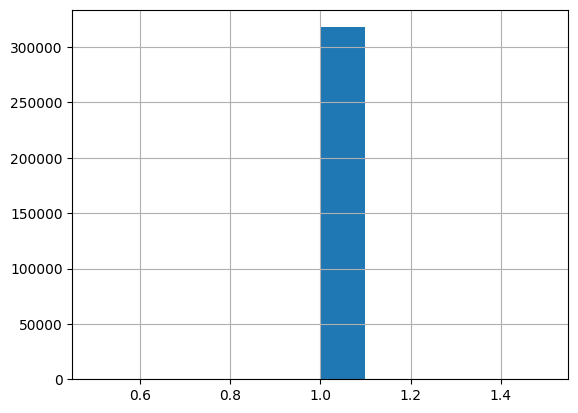

In [ ]:
data['diff'].hist()

The dataset is a bit crappy because it has different frame step: ranging from predominantly 1 and 2 to sometimes have 3 and 4 as well. This inevitabily leads to difference in speed caluclations

In [ ]:
if SRC_H is not None:
    H = np.loadtxt(SRC_H, delimiter=',')
else:
    H = None

In [ ]:
if H is not None:
    print("Projecting data")
    data['foot_x'] = data['pos_x'] + 0.5 * data['width']
    data['foot_y'] = data['pos_y'] + 0.5 * data['height']
    
    transformed = cv2.perspectiveTransform(np.array([data[['foot_x','foot_y']].to_numpy()]),H)[0]
    data['proj_x'], data['proj_y'] = transformed[:,0], transformed[:,1]
    data['proj_x'] = data['proj_x'].div(100) # cm to m
    data['proj_y'] = data['proj_y'].div(100) # cm to m
    # and shift to mean (THES NEED TO BE STORED AND REUSED IN LIVE SETTING)
    mean_x = data['proj_x'].mean()
    mean_y = data['proj_y'].mean()
    data['proj_x'] = data['proj_x'] - data['proj_x'].mean()
    data['proj_y'] = data['proj_y'] - data['proj_y'].mean()
else:
    print("No H given, probably already projected data?")
    mean_x = 0
    mean_y = 0
    data['proj_x']  = data['x']
    data['proj_y']  = data['y']
data

No H given, probably already projected data?


frame_id  track_id            l           t           w           h  \
0            9.0         1     0.000000  565.566162   88.795326  173.917542   
1           10.0         1     0.000000  565.116699   88.801704  171.334290   
2           11.0         1     0.000000  564.874573   90.596596  177.199951   
3           12.0         1     0.000000  564.874268   90.928131  183.125732   
4           13.0         1     0.000000  569.931213   86.213280  180.774292   
...          ...       ...          ...         ...         ...         ...   
320183   60159.0      3632  1830.709717  651.257446  150.202515  157.239746   
320184   60160.0      3632  1834.013672  649.612122  153.686646  160.874023   
320185   60161.0      3632  1845.373047  651.249756  147.178589  153.729248   
320186   60162.0      3632  1857.388916  650.908203  136.407349  142.354614   
320187   60163.0      3632  1862.792725  658.719971  141.984253  149.052307   

                x          y  state  diff      x_raw      y_raw        dt  \
0        0.855100   7.136193    2.0   NaN   0.881595   7.341152       NaN   
1        0.873132   7.235233    2.0   1.0   0.870703   7.309168  0.083333   
2        0.890957   7.328989    2.0   1.0   0.901374   7.370044  0.083333   
3        0.907784   7.418187    2.0   1.0   0.924360   7.432365  0.083333   
4        0.923439   7.505012    2.0   1.0   0.906583   7.456334  0.083333   
...           ...        ...    ...   ...        ...        ...       ...   
320183  14.840476   9.786501    2.0   NaN  15.214551  10.027093       NaN   
320184  15.033432   9.870472    2.0   1.0  15.244872  10.047117  0.083333   
320185  15.211560   9.943236    2.0   1.0  15.318496  10.015218  0.083333   
320186  15.377673  10.008965    2.0   1.0  15.400203   9.935355  0.083333   
320187  15.538255  10.075935    2.0   1.0  15.416893  10.051785  0.083333   

           proj_x     proj_y  
0        0.855100   7.136193  
1        0.873132   7.235233  
2        0.890957   7.328989  
3        0.907784   7.418187  
4        0.923439   7.505012  
...           ...        ...  
320183  14.840476   9.786501  
320184  15.033432   9.870472  
320185  15.211560   9.943236  
320186  15.377673  10.008965  
320187  15.538255  10.075935  

[320188 rows x 15 columns]

In [ ]:
print("Deriving displacement, velocity and accelation from x and y")
data['dx'] = data.groupby(['track_id'])['proj_x'].diff()
data['dy'] = data.groupby(['track_id'])['proj_y'].diff()
data['vx'] = data['dx'].div(data['dt'], axis=0)
data['vy'] = data['dy'].div(data['dt'], axis=0)

data['ax'] = data.groupby(['track_id'])['vx'].diff().div(data['dt'], axis=0)
data['ay'] = data.groupby(['track_id'])['vy'].diff().div(data['dt'], axis=0)

data

Deriving displacement, velocity and accelation from x and y


frame_id  track_id            l           t           w           h  \
0            9.0         1     0.000000  565.566162   88.795326  173.917542   
1           10.0         1     0.000000  565.116699   88.801704  171.334290   
2           11.0         1     0.000000  564.874573   90.596596  177.199951   
3           12.0         1     0.000000  564.874268   90.928131  183.125732   
4           13.0         1     0.000000  569.931213   86.213280  180.774292   
...          ...       ...          ...         ...         ...         ...   
320183   60159.0      3632  1830.709717  651.257446  150.202515  157.239746   
320184   60160.0      3632  1834.013672  649.612122  153.686646  160.874023   
320185   60161.0      3632  1845.373047  651.249756  147.178589  153.729248   
320186   60162.0      3632  1857.388916  650.908203  136.407349  142.354614   
320187   60163.0      3632  1862.792725  658.719971  141.984253  149.052307   

                x          y  state  diff  ...      y_raw        dt  \
0        0.855100   7.136193    2.0   NaN  ...   7.341152       NaN   
1        0.873132   7.235233    2.0   1.0  ...   7.309168  0.083333   
2        0.890957   7.328989    2.0   1.0  ...   7.370044  0.083333   
3        0.907784   7.418187    2.0   1.0  ...   7.432365  0.083333   
4        0.923439   7.505012    2.0   1.0  ...   7.456334  0.083333   
...           ...        ...    ...   ...  ...        ...       ...   
320183  14.840476   9.786501    2.0   NaN  ...  10.027093       NaN   
320184  15.033432   9.870472    2.0   1.0  ...  10.047117  0.083333   
320185  15.211560   9.943236    2.0   1.0  ...  10.015218  0.083333   
320186  15.377673  10.008965    2.0   1.0  ...   9.935355  0.083333   
320187  15.538255  10.075935    2.0   1.0  ...  10.051785  0.083333   

           proj_x     proj_y        dx        dy        vx        vy  \
0        0.855100   7.136193       NaN       NaN       NaN       NaN   
1        0.873132   7.235233  0.018032  0.099039  0.216383  1.188473   
2        0.890957   7.328989  0.017825  0.093756  0.213899  1.125077   
3        0.907784   7.418187  0.016827  0.089198  0.201924  1.070371   
4        0.923439   7.505012  0.015655  0.086825  0.187865  1.041902   
...           ...        ...       ...       ...       ...       ...   
320183  14.840476   9.786501       NaN       NaN       NaN       NaN   
320184  15.033432   9.870472  0.192955  0.083971  2.315463  1.007656   
320185  15.211560   9.943236  0.178128  0.072764  2.137542  0.873173   
320186  15.377673  10.008965  0.166113  0.065728  1.993352  0.788742   
320187  15.538255  10.075935  0.160582  0.066971  1.926987  0.803649   

              ax        ay  
0            NaN       NaN  
1            NaN       NaN  
2      -0.029812 -0.760753  
3      -0.143699 -0.656466  
4      -0.168701 -0.341637  
...          ...       ...  
320183       NaN       NaN  
320184       NaN       NaN  
320185 -2.135059 -1.613797  
320186 -1.730279 -1.013172  
320187 -0.796376  0.178886  

[320188 rows x 21 columns]

In [ ]:
# then we need the velocity itself
data['v'] = np.sqrt(data['vx'].pow(2) + data['vy'].pow(2))
# and derive acceleration
data['a'] = data.groupby(['track_id'])['v'].diff().div(data['dt'], axis=0)

# we can calculate heading based on the velocity components
data['heading'] = (np.arctan2(data['vy'], data['vx'])  * 180 / np.pi) % 360

# and derive it to get the rate of change of the heading
data['d_heading'] = data.groupby(['track_id'])['heading'].diff().div(data['dt'], axis=0)

data

frame_id  track_id            l           t           w           h  \
0            9.0         1     0.000000  565.566162   88.795326  173.917542   
1           10.0         1     0.000000  565.116699   88.801704  171.334290   
2           11.0         1     0.000000  564.874573   90.596596  177.199951   
3           12.0         1     0.000000  564.874268   90.928131  183.125732   
4           13.0         1     0.000000  569.931213   86.213280  180.774292   
...          ...       ...          ...         ...         ...         ...   
320183   60159.0      3632  1830.709717  651.257446  150.202515  157.239746   
320184   60160.0      3632  1834.013672  649.612122  153.686646  160.874023   
320185   60161.0      3632  1845.373047  651.249756  147.178589  153.729248   
320186   60162.0      3632  1857.388916  650.908203  136.407349  142.354614   
320187   60163.0      3632  1862.792725  658.719971  141.984253  149.052307   

                x          y  state  diff  ...        dx        dy        vx  \
0        0.855100   7.136193    2.0   NaN  ...       NaN       NaN       NaN   
1        0.873132   7.235233    2.0   1.0  ...  0.018032  0.099039  0.216383   
2        0.890957   7.328989    2.0   1.0  ...  0.017825  0.093756  0.213899   
3        0.907784   7.418187    2.0   1.0  ...  0.016827  0.089198  0.201924   
4        0.923439   7.505012    2.0   1.0  ...  0.015655  0.086825  0.187865   
...           ...        ...    ...   ...  ...       ...       ...       ...   
320183  14.840476   9.786501    2.0   NaN  ...       NaN       NaN       NaN   
320184  15.033432   9.870472    2.0   1.0  ...  0.192955  0.083971  2.315463   
320185  15.211560   9.943236    2.0   1.0  ...  0.178128  0.072764  2.137542   
320186  15.377673  10.008965    2.0   1.0  ...  0.166113  0.065728  1.993352   
320187  15.538255  10.075935    2.0   1.0  ...  0.160582  0.066971  1.926987   

              vy        ax        ay         v         a    heading  d_heading  
0            NaN       NaN       NaN       NaN       NaN        NaN        NaN  
1       1.188473       NaN       NaN  1.208011       NaN  79.681298        NaN  
2       1.125077 -0.029812 -0.760753  1.145230 -0.753373  79.235449  -5.350188  
3       1.070371 -0.143699 -0.656466  1.089251 -0.671740  79.316807   0.976297  
4       1.041902 -0.168701 -0.341637  1.058703 -0.366576  79.778828   5.544252  
...          ...       ...       ...       ...       ...        ...        ...  
320183       NaN       NaN       NaN       NaN       NaN        NaN        NaN  
320184  1.007656       NaN       NaN  2.525221       NaN  23.517970        NaN  
320185  0.873173 -2.135059 -1.613797  2.309007 -2.594562  22.219713 -15.579091  
320186  0.788742 -1.730279 -1.013172  2.143727 -1.983366  21.588019  -7.580324  
320187  0.803649 -0.796376  0.178886  2.087853 -0.670484  22.638547  12.606340  

[320188 rows x 25 columns]

In [ ]:
# we can backfill the v and a, so that our model can make estimations
# based on these assumed values
data['v'] = data.groupby(['track_id'])['v'].bfill()
data['a'] = data.groupby(['track_id'])['a'].bfill()

data['heading'] = data.groupby(['track_id'])['heading'].bfill()
data['d_heading'] = data.groupby(['track_id'])['d_heading'].bfill()
data

frame_id  track_id            l           t           w           h  \
0            9.0         1     0.000000  565.566162   88.795326  173.917542   
1           10.0         1     0.000000  565.116699   88.801704  171.334290   
2           11.0         1     0.000000  564.874573   90.596596  177.199951   
3           12.0         1     0.000000  564.874268   90.928131  183.125732   
4           13.0         1     0.000000  569.931213   86.213280  180.774292   
...          ...       ...          ...         ...         ...         ...   
320183   60159.0      3632  1830.709717  651.257446  150.202515  157.239746   
320184   60160.0      3632  1834.013672  649.612122  153.686646  160.874023   
320185   60161.0      3632  1845.373047  651.249756  147.178589  153.729248   
320186   60162.0      3632  1857.388916  650.908203  136.407349  142.354614   
320187   60163.0      3632  1862.792725  658.719971  141.984253  149.052307   

                x          y  state  diff  ...        dx        dy        vx  \
0        0.855100   7.136193    2.0   NaN  ...       NaN       NaN       NaN   
1        0.873132   7.235233    2.0   1.0  ...  0.018032  0.099039  0.216383   
2        0.890957   7.328989    2.0   1.0  ...  0.017825  0.093756  0.213899   
3        0.907784   7.418187    2.0   1.0  ...  0.016827  0.089198  0.201924   
4        0.923439   7.505012    2.0   1.0  ...  0.015655  0.086825  0.187865   
...           ...        ...    ...   ...  ...       ...       ...       ...   
320183  14.840476   9.786501    2.0   NaN  ...       NaN       NaN       NaN   
320184  15.033432   9.870472    2.0   1.0  ...  0.192955  0.083971  2.315463   
320185  15.211560   9.943236    2.0   1.0  ...  0.178128  0.072764  2.137542   
320186  15.377673  10.008965    2.0   1.0  ...  0.166113  0.065728  1.993352   
320187  15.538255  10.075935    2.0   1.0  ...  0.160582  0.066971  1.926987   

              vy        ax        ay         v         a    heading  d_heading  
0            NaN       NaN       NaN  1.208011 -0.753373  79.681298  -5.350188  
1       1.188473       NaN       NaN  1.208011 -0.753373  79.681298  -5.350188  
2       1.125077 -0.029812 -0.760753  1.145230 -0.753373  79.235449  -5.350188  
3       1.070371 -0.143699 -0.656466  1.089251 -0.671740  79.316807   0.976297  
4       1.041902 -0.168701 -0.341637  1.058703 -0.366576  79.778828   5.544252  
...          ...       ...       ...       ...       ...        ...        ...  
320183       NaN       NaN       NaN  2.525221 -2.594562  23.517970 -15.579091  
320184  1.007656       NaN       NaN  2.525221 -2.594562  23.517970 -15.579091  
320185  0.873173 -2.135059 -1.613797  2.309007 -2.594562  22.219713 -15.579091  
320186  0.788742 -1.730279 -1.013172  2.143727 -1.983366  21.588019  -7.580324  
320187  0.803649 -0.796376  0.178886  2.087853 -0.670484  22.638547  12.606340  

[320188 rows x 25 columns]

In [ ]:
filtered_data = data.groupby(['track_id']).filter(lambda group: len(group) >= window+1) # a lenght of 3 is neccessary to have all relevant derivatives of position
filtered_data = filtered_data.set_index(['track_id', 'frame_id']) # use for quick access
print(filtered_data.shape[0], "items in filtered set, out of", data.shape[0], "in total set")

312423 items in filtered set, out of 320188 in total set


In [ ]:
track_ids = filtered_data.index.unique('track_id').to_numpy()
np.random.shuffle(track_ids)
test_offset_idx = int(len(track_ids) * .8)
training_ids, test_ids = track_ids[:test_offset_idx], track_ids[test_offset_idx:]
print(f"{len(training_ids)} training tracks, {len(test_ids)} test tracks")

1263 training tracks, 316 test tracks


here, draw out a sample track to see if it looks alright. **unfortunately the imate isn't mapped properly**.

1058


0 0


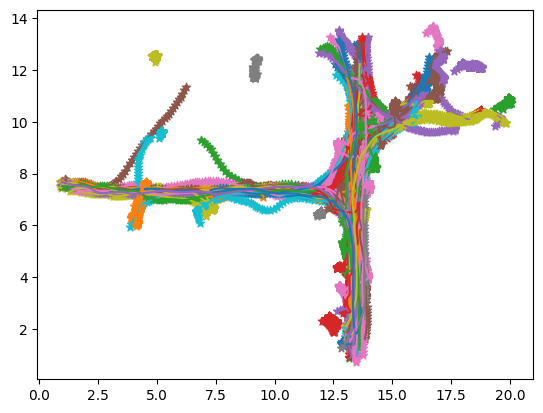

In [ ]:
import random
if H:
    img_src = "../DATASETS/hof/webcam20231103-2.png"
    # dst = cv2.warpPerspective(img_src,H,(2500,1920))
    src_img = cv2.imread(img_src)
    print(src_img.shape)
    h1,w1 = src_img.shape[:2]
    corners = np.float32([[0,0], [w1, 0], [0, h1], [w1, h1]])

    print(corners)
    corners_projected = cv2.perspectiveTransform(corners.reshape((-1,4,2)), H)[0]
    print(corners_projected)
    [xmin, ymin] = np.int32(corners_projected.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(corners_projected.max(axis=0).ravel() + 0.5)
    print(xmin, xmax, ymin, ymax)

    dst = cv2.warpPerspective(src_img,H, (xmax, ymax))
    def plot_track(track_id: int):
        plt.gca().invert_yaxis()

        plt.imshow(dst, origin='lower', extent=[xmin/100-mean_x, xmax/100-mean_x, ymin/100-mean_y, ymax/100-mean_y])
        # plot scatter plot with x and y data 
        
        ax = plt.scatter(
            filtered_data.loc[track_id,:]['proj_x'],
            filtered_data.loc[track_id,:]['proj_y'],
            marker="*") 
        ax.axes.invert_yaxis()
        plt.plot(
            filtered_data.loc[track_id,:]['proj_x'],
            filtered_data.loc[track_id,:]['proj_y']
        )
else:
    def plot_track(track_id: int):
        ax = plt.scatter(
            filtered_data.loc[track_id,:]['x'],
            filtered_data.loc[track_id,:]['y'],
            marker="*") 
        plt.plot(
            filtered_data.loc[track_id,:]['proj_x'],
            filtered_data.loc[track_id,:]['proj_y']
        )

# print(filtered_data.loc[track_id,:]['proj_x'])
# _track_id = 2188
_track_id = random.choice(track_ids)
print(_track_id)
plot_track(_track_id)

for track_id in random.choices(track_ids, k=100):
    plot_track(track_id)
    
print(mean_x, mean_y)

Now make the dataset:

In [ ]:
# a=filtered_data.loc[1]
# min(a.index.tolist())

In [ ]:



def create_dataset(data, track_ids, window):
    X, y, = [], []
    for track_id in tqdm(track_ids):
        df = data.loc[track_id]
        start_frame = min(df.index.tolist())
        for step in range(len(df)-window-1):
            i = int(start_frame) + step
            # print(step, int(start_frame), i)
            feature = df.loc[i:i+window][in_fields]
            # target = df.loc[i+1:i+window+1][out_fields]
            target = df.loc[i+window+1][out_fields]
            X.append(feature.values)
            y.append(target.values)
            
    return torch.tensor(np.array(X), dtype=torch.float), torch.tensor(np.array(y), dtype=torch.float)

X_train, y_train = create_dataset(filtered_data, training_ids, window)
X_test, y_test = create_dataset(filtered_data, test_ids, window)

  0%|          | 0/1263 [00:00<?, ?it/s]

100%|██████████| 316/316 [00:26<00:00, 11.75it/s]


In [ ]:
X_train, y_train = X_train.to(device=device), y_train.to(device=device)
X_test, y_test = X_test.to(device=device), y_test.to(device=device)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
dataset_train = TensorDataset(X_train, y_train)
loader_train = DataLoader(dataset_train, shuffle=True, batch_size=8)

Model give output for all timesteps, this should improve training. But we use only the last timestep for the prediction process

In [ ]:
class LSTMModel(nn.Module):
    # input_size : number of features in input at each time step
    # hidden_size : Number of LSTM units 
    # num_layers : number of LSTM layers 
    def __init__(self, input_size, hidden_size, num_layers): 
        super(LSTMModel, self).__init__() #initializes the parent class nn.Module
        self.lin1 = nn.Linear(input_size, hidden_size//2)
        self.lstm = nn.LSTM(hidden_size//2, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        # self.activation_v = nn.LeakyReLU(.01)
        # self.activation_heading = torch.remainder()

    def forward(self, x): # defines forward pass of the neural network
        out = self.lin1(x)
        out, h0 = self.lstm(out)
        # extract only the last time step, see https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/
        # print(out.shape)
        out = out[:, -1,:]
        # print(out.shape)
        out = self.linear(out)
        
        #  torch.remainder(out[1], 360)
        # print('o',out.shape)
        return out

model = LSTMModel(input_size, hidden_size, num_layers).to(device)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

In [ ]:
def evaluate():
    # toggle evaluation mode
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train.to(device=device))
        train_rmse = torch.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test.to(device=device))
        test_rmse = torch.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

def load_most_recent():
    paths = list(cache_path.glob("checkpoint_*.pt"))
    if len(paths) < 1:
        print('Nothing found to load')
        return None, None
    paths.sort()

    print(f"Loading {paths[-1]}")
    return load_cache(path=paths[-1])

def load_cache(epoch=None, path=None):
    if path is None:
        if epoch is None:
            raise RuntimeError("Either path or epoch must be given")
        path = cache_path / f"checkpoint_{epoch:05d}.pt"
    else:
        print (path.stem)
        epoch = int(path.stem[-5:])

    cached = torch.load(path)
    
    optimizer.load_state_dict(cached['optimizer_state_dict'])
    model.load_state_dict(cached['model_state_dict'])
    return epoch, cached['loss']
    

def cache(epoch, loss):
    path = cache_path / f"checkpoint_{epoch:05d}.pt"
    print(f"Cache to {path}")
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, path)


In [ ]:
start_epoch, loss = load_most_recent()
if start_epoch is None:
    start_epoch = 0
else:
    print(f"starting from epoch {start_epoch} (loss: {loss})")

# Train Network
for epoch in tqdm(range(start_epoch+1,num_epochs+1)):
    # toggle train mode
    model.train()
    for batch_idx, (data, targets) in enumerate(loader_train):
        # Get data to cuda if possible
        data = data.to(device=device).squeeze(1)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = loss_fn(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent update step/adam step
        optimizer.step()

    if epoch % 5 != 0:
        continue

    cache(epoch, loss)
    evaluate()

evaluate()

Loading EXPERIMENTS/cache/hof2/checkpoint_00005.pt
checkpoint_00005
starting from epoch 5 (loss: nan)


  0%|          | 0/95 [00:00<?, ?it/s]

  4%|▍         | 4/95 [07:37<2:53:27, 114.37s/it]

Cache to EXPERIMENTS/cache/hof2/checkpoint_00010.pt


RuntimeError: CUDA out of memory. Tried to allocate 28.40 GiB (GPU 0; 23.59 GiB total capacity; 15.01 GiB already allocated; 7.20 GiB free; 15.03 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [1]:
model.eval()
with torch.no_grad():
    y_pred = model(X_train.to(device=device))
    print(y_pred.shape, y_train.shape)
y_train, y_pred

NameError: name 'model' is not defined

In [ ]:
mean_x, mean_y

(0, 0)

In [ ]:
import scipy


def predict_and_plot(feature, steps = 50):
    lenght = feature.shape[0]
    # feature = filtered_data.loc[_track_id,:].iloc[:5][in_fields].values
    # nxt = filtered_data.loc[_track_id,:].iloc[5][out_fields]
    with torch.no_grad():
        for i in range(steps):
            # predict_f = scipy.ndimage.uniform_filter(feature)
            # predict_f = scipy.interpolate.splrep(feature[:][0], feature[:][1],)
            # predict_f = scipy.signal.spline_feature(feature, lmbda=.1)
            # bathc size of one, so feature as single item in array
            X = torch.tensor([feature], dtype=torch.float).to(device)
            # print(X.shape)
            s = model(X)[0].cpu()
            
            #  proj_x    proj_y         v     heading          a    d_heading
            # next_step = feature
            dt = 1/ FPS
            v = np.sqrt(s[0]**2 + s[1]**2)
            heading = (np.arctan2(s[1], s[0])  * 180 / np.pi) % 360
            a = (v - feature[-1][2]) / dt
            d_heading = (heading - feature[-1][5])
            # print(s)
            feature  = np.append(feature, [[feature[-1][0] + s[0]*dt, feature[-1][1] + s[1]*dt, v, heading, a, d_heading ]], axis=0)
            
            # print(next_step, nxt)
    plt.plot(feature[:lenght,0], feature[:lenght,1], c='orange')
    plt.plot(feature[lenght-1:,0], feature[lenght-1:,1], c='red')
    plt.scatter(feature[lenght:,0], feature[lenght:,1], c='red')

2515


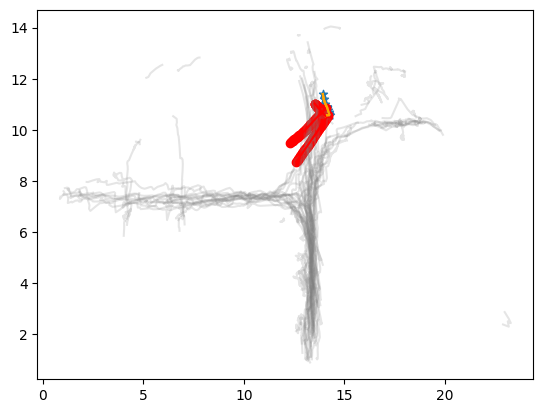

In [ ]:

# print(filtered_data.loc[track_id,:]['proj_x'])
_track_id =  8701 # random.choice(track_ids)
_track_id =  3880 # random.choice(track_ids)

# _track_id = 2780

for i in range(100):
    _track_id = random.choice(track_ids)
    plt.plot(
        filtered_data.loc[_track_id,:]['proj_x'],
        filtered_data.loc[_track_id,:]['proj_y'],
        c='grey', alpha=.2
    )

_track_id = random.choice(track_ids)
# _track_id = 801
print(_track_id)
ax = plt.scatter(
    filtered_data.loc[_track_id,:]['proj_x'],
    filtered_data.loc[_track_id,:]['proj_y'],
    marker="*") 
plt.plot(
    filtered_data.loc[_track_id,:]['proj_x'],
    filtered_data.loc[_track_id,:]['proj_y']
)

predict_and_plot(filtered_data.loc[_track_id,:].iloc[:5][in_fields].values)
predict_and_plot(filtered_data.loc[_track_id,:].iloc[:10][in_fields].values)
predict_and_plot(filtered_data.loc[_track_id,:].iloc[:50][in_fields].values)
# predict_and_plot(filtered_data.loc[_track_id,:].iloc[:70][in_fields].values)
# predict_and_plot(filtered_data.loc[_track_id,:].iloc[:115][in_fields].values)